# Random Features For Goyal Welch Data
by Guillaume IDAME KORALAGE

## Librairies

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

import math

## Functions

In [2]:
def scatter_plot(x_: np.ndarray,
                 y_: np.ndarray,
                 name_x: str,
                 name_y: str,
                 ax=None):
    """
    scatter plot
    """
    data = pd.DataFrame(np.concatenate([x_, y_], axis=1),
                    columns=[name_x, name_y])
    if ax is None:
        sns.jointplot(data=data, x=name_x, y=name_y, kind="reg")
    else:
        sns.jointplot(data=data, x=name_x, y=name_y, kind="reg", ax=ax)

In [3]:
def performance_metrics_of_regression(labels: np.ndarray,
                                      predictions: np.ndarray) -> tuple:
    """
    Compute standard performance metrics for regression: mse and Rsquared
    """
    mse = ((predictions - labels) ** 2).mean()
    r2 = 1 - mse / (labels ** 2).mean()
    print(f'r2 = {"%.2f" % r2}, mse = {"%.2f" % mse}')

    return mse, r2

In [4]:
def ridge_regr(signals: np.ndarray,
                  labels: np.ndarray,
                  future_signals: np.ndarray,
                  shrinkage_list: np.ndarray):
    """
    Regression is
    beta = (zI + S'S/t)^{-1}S'y/t = S' (zI+SS'/t)^{-1}y/t
    Inverting matrices is costly, so we use eigenvalue decomposition:
    (zI+A)^{-1} = U (zI+D)^{-1} U' where UDU' = A is eigenvalue decomposition,
    and we use the fact that D @ B = (diag(D) * B) for diagonal D, which saves a lot of compute cost
    :param signals: S
    :param labels: y
    :param future_signals: out of sample y
    :param shrinkage_list: list of ridge parameters
    :return:
    """
    t_ = signals.shape[0]
    p_ = signals.shape[1]
    if p_ < t_:
        # this is standard regression
        eigenvalues, eigenvectors = np.linalg.eigh(signals.T @ signals / t_)
        means = signals.T @ labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        betas = eigenvectors @ intermed
    else:
        # this is the weird over-parametrized regime
        eigenvalues, eigenvectors = np.linalg.eigh(signals @ signals.T / t_)
        means = labels.reshape(-1, 1) / t_
        multiplied = eigenvectors.T @ means
        intermed = np.concatenate([(1 / (eigenvalues.reshape(-1, 1) + z)) * multiplied for z in shrinkage_list],
                                  axis=1)
        tmp = eigenvectors.T @ signals
        betas = tmp.T @ intermed
    predictions = future_signals @ betas
    return betas, predictions

In [5]:
def normalize(data: np.ndarray,
              ready_normalization: dict = None,
              use_std: bool = False):
  """

  """

  if ready_normalization is None:
      data_std = data.std(0)
      if use_std:
        data = data / data_std
      else:
        data_max = np.max(data, axis=0)
        data_min = np.min(data, axis=0)
  else:
      data_std = ready_normalization['std']
      if use_std:
        data = data / data_std
      else:
        data_max = ready_normalization['max']
        data_min = ready_normalization['min']

  data = data - data_min
  data = data/(data_max - data_min)
  data = data - 0.5
  normalization = {'std': data_std,
                    'max': data_max,
                    'min': data_min}
  return data, normalization

In [6]:
def regression_with_tstats(predicted_variable, explanatory_variables):
    x_ = explanatory_variables
    x_ = sm.add_constant(x_)
    y_ = predicted_variable
    # Newey-West standard errors with maxlags
    z_ = x_.copy().astype(float)
    result = sm.OLS(y_.values, z_.values).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
    try:
        tstat = np.round(result.summary2().tables[1]['z'], 1)  # alpha t-stat (because for 'const')
        tstat.index = list(z_.columns)
    except:
        print(f'something is wrong for t-stats')
    return tstat

In [7]:
def sharpe_ratio(x):
  return np.round(np.sqrt(12) * x.mean(0) / x.std(0), 2)

We now experiment with random features ([Random Features for Large-Scale Kernel Machines](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf)) applied to the classic dataset from [A Comprehensive Look at the Empirical Performance of Equity Premium Prediction](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=517667) and implemented in [The Virtue of Complexity in Return Prediction](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3984925)

In [8]:
path_goyal_welch = "C:/Users/idame/OneDrive/Documents/Guillaume/Education/EDHEC M2 FENG/Deep Learning For Finance/macro_data/GoyalWelchPredictorData2022Monthly.csv"
path_fred = "C:/Users/idame/OneDrive/Documents/Guillaume/Education/EDHEC M2 FENG/Deep Learning For Finance/macro_data/FRED_MD.csv"

In [9]:
goyal_welch_data = pd.read_csv(path_goyal_welch, index_col = 0)
goyal_welch_data.index = pd.to_datetime(goyal_welch_data.index, format='%Y%m')
goyal_welch_data.dropna(how = "all", axis = 0, inplace = True)
goyal_welch_data.dropna(how = "all", axis = 1, inplace = True)
for column in goyal_welch_data.columns:
    goyal_welch_data[column] = [float(str(x).replace(',', '')) for x in goyal_welch_data[column]]

fred_data = pd.read_csv(path_fred, index_col = 0)
fred_data.drop("Transform:", axis = 0, inplace = True)
fred_data.index = pd.to_datetime(fred_data.index, format='%d/%m/%Y')
fred_data.dropna(how = "all", axis = 0, inplace = True)
fred_data.dropna(how = "all", axis = 1, inplace = True)

In [10]:
goyal_welch_data.describe()

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
count,1824.000000,1824.000000,1824.000000,1222.000000,1236.000000,1248.000000,1248.000000,1248.000000,1153.000000,1823.000000,1319.000000,1164.000000,1164.000000,1655.000000,788.000000,1164.000000,1164.000000
mean,358.525828,7.282283,17.059570,0.550079,0.033287,0.056501,0.068216,0.049241,0.015959,0.002924,0.002610,0.004496,0.004943,0.002553,0.000364,0.009410,0.006304
std,764.190480,13.216268,33.406115,0.261466,0.029734,0.026715,0.028346,0.027063,0.025725,0.002143,0.006433,0.024830,0.022118,0.005149,0.002375,0.054172,0.054242
min,2.730000,0.180000,0.160000,0.120510,0.000100,0.021400,0.029400,0.006200,-0.055954,-0.000600,-0.031579,-0.112400,-0.094900,0.000000,-0.004166,-0.287461,-0.291524
25%,7.920000,0.423300,0.568950,0.328985,0.006350,0.036100,0.048175,0.028100,0.003558,0.001300,0.000000,-0.007525,-0.004600,0.000723,-0.001594,-0.016868,-0.019211
50%,17.835000,0.911650,1.513650,0.527069,0.029650,0.049150,0.062400,0.041700,0.015946,0.002900,0.002404,0.003000,0.004000,0.001241,-0.000284,0.013000,0.009393
75%,170.990000,7.540825,14.861675,0.728375,0.050300,0.073000,0.083500,0.064100,0.027018,0.004000,0.005473,0.015925,0.013700,0.002308,0.002296,0.038778,0.035916
max,4766.180000,66.922800,197.910000,2.028478,0.163000,0.154900,0.171800,0.148200,0.177040,0.013500,0.058824,0.152300,0.156000,0.073153,0.007688,0.414312,0.412291


In [11]:
goyal_welch_data.corr()

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
Index,1.000000,0.976952,0.971674,-0.586955,-0.233160,-0.151000,-0.187700,-0.217137,-0.388406,-0.256399,-0.010084,-0.034677,-0.019966,0.024068,-0.394410,0.003758,0.019214
D12,0.976952,1.000000,0.967866,-0.566695,-0.195115,-0.089142,-0.124923,-0.156467,-0.449804,-0.226416,-0.016082,-0.010813,0.001501,0.041149,-0.591115,-0.005382,0.009796
E12,0.971674,0.967866,1.000000,-0.552464,-0.181918,-0.100869,-0.143726,-0.160729,-0.407763,-0.214650,0.000675,-0.018821,-0.017731,0.006350,-0.520702,-0.007065,0.007905
b/m,-0.586955,-0.566695,-0.552464,1.000000,0.199958,0.160981,0.260409,0.197314,0.034194,0.192322,0.073090,0.009947,-0.000043,0.169768,0.273217,-0.045084,-0.064466
tbl,-0.233160,-0.195115,-0.181918,0.199958,1.000000,0.888219,0.828238,0.901584,0.032109,0.987950,0.201720,0.053990,0.032672,-0.151561,-0.583011,-0.019120,-0.019864
AAA,-0.151000,-0.089142,-0.100869,0.160981,0.888219,1.000000,0.970474,0.988194,-0.082484,0.880914,0.159846,0.105842,0.101953,-0.047285,-0.650444,-0.009374,-0.007710
BAA,-0.187700,-0.124923,-0.143726,0.260409,0.828238,0.970474,1.000000,0.944715,-0.119387,0.824402,0.094729,0.116887,0.118228,0.074055,-0.601867,-0.011657,-0.011785
lty,-0.217137,-0.156467,-0.160729,0.197314,0.901584,0.988194,0.944715,1.000000,-0.061977,0.890538,0.184884,0.056213,0.054396,-0.099717,-0.657265,-0.010755,-0.010226
ntis,-0.388406,-0.449804,-0.407763,0.034194,0.032109,-0.082484,-0.119387,-0.061977,1.000000,0.032430,-0.055086,-0.045876,-0.042822,-0.039215,0.248873,-0.068233,-0.073075
Rfree,-0.256399,-0.226416,-0.214650,0.192322,0.987950,0.880914,0.824402,0.890538,0.032430,1.000000,0.177283,0.091004,0.066322,-0.122932,-0.587353,-0.016362,-0.016427


Excess returns are defined as $R_{t+1}-r_{f,t}$ (in excess of the risk-free rate)

In [12]:
goyal_welch_data["returns"] = ((goyal_welch_data["Index"])/ goyal_welch_data["Index"].shift(1) - 1).fillna(0)
goyal_welch_data['excess_returns'] = goyal_welch_data["returns"] - goyal_welch_data["Rfree"]

In [13]:
goyal_welch_data.columns

Index(['Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis',
       'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx', 'returns', 'excess_returns'],
      dtype='object')

In [14]:
goyal_welch_data.tail(20)

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx,returns,excess_returns
yyyymm,,,,,,,,,,,,,,,,,,,
2021-05-01,4204.11,57.7878,148.5733,0.184798,0.0002,0.0296,0.0362,0.0162,0.017464,0.0000,0.008017,0.0001,0.0045,0.001496,NaN,0.006208,0.004737,0.005487,0.005487
2021-06-01,4297.50,57.8650,158.7600,0.184942,0.0004,0.0279,0.0344,0.0152,0.017255,0.0000,0.009291,0.0284,0.0442,0.000607,NaN,0.023682,0.022564,0.022214,0.022214
2021-07-01,4395.26,58.3282,164.2967,0.182650,0.0005,0.0257,0.0324,0.0132,0.016079,0.0000,0.004811,0.0305,0.0239,0.001124,NaN,0.024305,0.023309,0.022748,0.022748
2021-08-01,4522.68,58.7913,169.8333,0.180453,0.0005,0.0255,0.0324,0.0128,0.014846,0.0000,0.002066,-0.0035,-0.0045,0.000602,NaN,0.030600,0.029205,0.028990,0.028990
2021-09-01,4307.54,59.2545,175.3700,0.188541,0.0004,0.0253,0.0323,0.0137,0.015598,0.0000,0.002716,-0.0250,-0.0194,0.001393,NaN,-0.046076,-0.047152,-0.047569,-0.047569
2021-10-01,4605.38,59.6354,182.8700,0.178142,0.0005,0.0268,0.0335,0.0158,0.013368,0.0000,0.008308,0.0051,0.0159,0.001151,NaN,0.070510,0.069627,0.069144,0.069144
2021-11-01,4567.00,60.0162,190.3700,0.185043,0.0005,0.0262,0.0328,0.0156,0.015640,0.0001,0.004913,0.0210,0.0094,0.001327,NaN,-0.007256,-0.008666,-0.008334,-0.008434
2021-12-01,4766.18,60.3971,197.8700,0.175599,0.0006,0.0265,0.0330,0.0147,0.012974,0.0000,0.003073,-0.0110,-0.0129,0.002518,NaN,0.043485,0.042285,0.043613,0.043613
2022-01-01,4515.55,60.9214,197.8833,0.181629,0.0015,0.0293,0.0358,0.0176,0.011640,0.0000,0.008415,-0.0227,-0.0522,0.002780,NaN,-0.052243,-0.053087,-0.052585,-0.052585


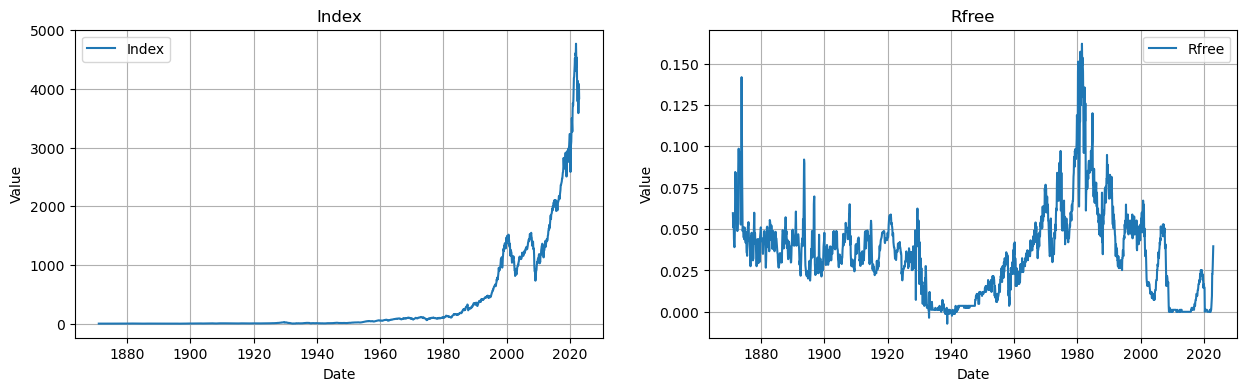

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (15,4))
axs[0].plot(goyal_welch_data['Index'], label = goyal_welch_data['Index'].name)
axs[0].set_title("Index")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Value")
axs[0].legend()
axs[0].grid()

axs[1].plot(12 * goyal_welch_data["Rfree"], label = goyal_welch_data['Rfree'].name)
axs[1].set_title("Rfree")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Value")
axs[1].legend()
axs[1].grid()

Excess returns are defined as $R_{t+1}-r_{f,t}$ (in excess of the risk-free rate). Then, we know that, with portfolio weight $\pi_t,$ the wealth evolves as
$$
W_{t+1}\ =\ W_t(r_{f,t} + \pi_t (R_{t+1}-r_{f,t}))
$$

In [16]:
leverage = 2
strategy_monthly_returns = goyal_welch_data["Rfree"] + leverage * goyal_welch_data["excess_returns"]
strategy_cumul_returns = np.cumprod(1 + strategy_monthly_returns)

strategy_monthly_returns = strategy_monthly_returns.to_frame(name = "Monthly returns")
strategy_cumul_returns = strategy_cumul_returns.to_frame(name = "Cumul returns")

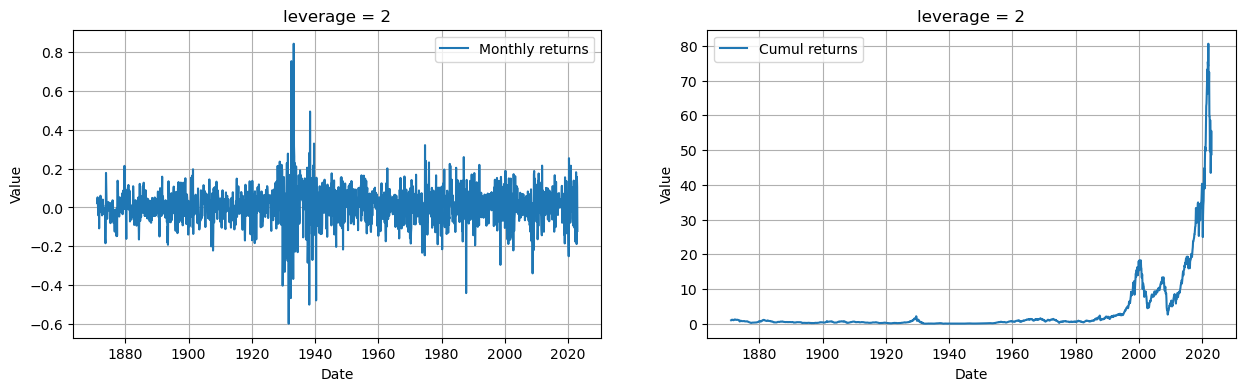

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
axs[0].plot(strategy_monthly_returns, label = strategy_monthly_returns.columns[0])
axs[0].set_title(f"leverage = {leverage}")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Value")
axs[0].legend()
axs[0].grid()

axs[1].plot(strategy_cumul_returns, label = strategy_cumul_returns.columns[0])
axs[1].set_title(f"leverage = {leverage}")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Value")
axs[1].legend()
axs[1].grid()

In [18]:
cleaned_data = goyal_welch_data.loc['1975':].drop(columns=['csp']).fillna(0)
cleaned_data

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,CRSP_SPvw,CRSP_SPvwx,returns,excess_returns
yyyymm,,,,,,,,,,,,,,,,,,
1975-01-01,76.98,3.6233,8.7433,0.980830,0.0626,0.0883,0.1081,0.0796,0.008510,0.0058,0.003854,0.0225,0.0596,0.004017,0.123610,0.121698,0.122812,0.117012
1975-02-01,81.59,3.6467,8.5967,0.933902,0.0550,0.0862,0.1065,0.0788,0.011652,0.0043,0.007678,0.0131,0.0137,0.002179,0.067460,0.059497,0.059886,0.055586
1975-03-01,83.36,3.6700,8.4500,0.972466,0.0549,0.0867,0.1048,0.0824,0.020467,0.0041,0.003810,-0.0267,-0.0247,0.002403,0.024014,0.022122,0.021694,0.017594
1975-04-01,87.30,3.6833,8.2867,0.909489,0.0561,0.0895,0.1058,0.0852,0.022496,0.0044,0.003795,-0.0182,-0.0052,0.002314,0.049424,0.047293,0.047265,0.042865
1975-05-01,91.15,3.6967,8.1233,0.897524,0.0523,0.0890,0.1069,0.0836,0.022954,0.0044,0.005671,0.0212,0.0106,0.001807,0.051193,0.044794,0.044101,0.039701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,3955.00,64.8854,188.8067,0.227429,0.0263,0.0407,0.0515,0.0290,-0.009732,0.0019,-0.000354,-0.0421,-0.0293,0.003349,-0.040305,-0.042052,-0.042440,-0.044340
2022-09-01,3585.62,65.3183,187.0800,0.249478,0.0313,0.0459,0.0569,0.0352,-0.011292,0.0019,0.002151,-0.0769,-0.0526,0.004934,-0.091495,-0.092876,-0.093396,-0.095296
2022-10-01,3871.98,65.8531,182.3033,0.218935,0.0372,0.0510,0.0626,0.0398,-0.015252,0.0023,0.004056,-0.0139,-0.0103,0.006504,0.080248,0.079196,0.079863,0.077563


#### Do not forget to shift the signals !!!!

In [19]:
signal_columns = ['Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis',
        'Rfree', 'infl', 'ltr', 'corpr', 'svar']


data_for_signals = cleaned_data[signal_columns].shift(1).fillna(0) # shifting of signals happens here !
labels = cleaned_data.excess_returns.values.reshape(-1, 1)
signals = data_for_signals.values
data_for_signals.shape, data_for_signals.columns

((576, 14),
 Index(['Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis',
        'Rfree', 'infl', 'ltr', 'corpr', 'svar'],
       dtype='object'))

Now comes (as usual) our favorite regression function
Recall that we would like to compute $(zI+SS'/T)^{-1}$ for many values of $z.$ Doing this is slow because matrix inversion is slow. 

Instead, we will only pay the cost of matrix manipulations just once. We do this by performing the eigenvalue decomposition
$$
SS'/T\ =\ U DU'
$$

and then use the mathematical formula
$$
(zI+SS'/T)^{-1}\ =\ U (zI+D)^{-1}U'\,.
$$

The **estimated** regression coefficients for $y=S\beta+\epsilon$ are
$$
\hat\beta(z)\ =\ (zI+S'S/T)^{-1}S'y/T\ =\ S'(zI+SS'/T)^{-1}y/T
$$

and we can thus rewrite it as
$$
S'(zI+SS'/T)^{-1}y/T\ =\ S'U (zI+D)^{-1}U' y/T\,.
$$

So we proceed as follows. First, we compute
$$
\mu\ =\ U' y/T
$$

Now, let $\delta$ be the vector of diagoal elements of $D$. Then,
$$
[(z_1I+D)^{-1}\mu, \cdots, (z_KI+D)^{-1}\mu]\ =\ [(z_1+\delta)^{-1}, \cdots, (z_K+\delta)^{-1}]*\mu
$$

Here, $[(z_1+\delta)^{-1}, \cdots, (z_K+\delta)^{-1}]$ is the matrix with $K$ columns and $T$ rows, because $\mu$ and $\delta$ are $T$-dimensional.


In [20]:
normalize_raw_data = True
cheat_and_use_future_data = False  # set to True if you want to have
#our fun experiment to show how even know a bit about the future can drastically imprpve performance

shrinkage_list = [0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

split = int(signals.shape[0] / 2)
train_labels = labels[:split]
test_labels = labels[split:]

if normalize_raw_data:
    signals[:split, :], normalization = normalize(signals[:split])
    # this is our fun experiment to show how even know a bit about the future can drastically imprpve performance
    if cheat_and_use_future_data:
      signals[split:, :] = normalize(signals[split:, :])[0]
    else:
      signals[split:, :] = normalize(signals[split:, :],
                                     ready_normalization=normalization)[0]

beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=signals[:split, :],
                                                                labels=train_labels,
                                                                future_signals=signals[split:, :],
                                                                shrinkage_list=shrinkage_list)
oos_predictions = pd.DataFrame(oos_predictions, index=cleaned_data.index[split:], columns = shrinkage_list)
oos_predictions

,1.000000e-08,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01,1.000000e+00,1.000000e+01,1.000000e+02,1.000000e+03
yyyymm,,,,,,,,,,
1999-01-01,0.020752,0.020437,0.019265,0.017546,0.013941,0.008614,0.002415,0.000294,0.000030,0.000003
1999-02-01,0.013982,0.013735,0.012989,0.013411,0.013013,0.008352,0.002305,0.000279,0.000028,0.000003
1999-03-01,0.012968,0.012754,0.011845,0.010310,0.008255,0.006878,0.002245,0.000279,0.000029,0.000003
1999-04-01,0.004284,0.004295,0.004674,0.007202,0.008636,0.006843,0.002109,0.000259,0.000027,0.000003
1999-05-01,-0.013579,-0.013260,-0.011532,-0.004792,0.002893,0.005135,0.001857,0.000232,0.000024,0.000002
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.267654,0.257956,0.226687,0.181337,0.086934,0.028819,0.006883,0.000800,0.000081,0.000008
2022-09-01,0.261073,0.252548,0.224263,0.178136,0.081648,0.027117,0.006747,0.000791,0.000080,0.000008
2022-10-01,0.268867,0.260023,0.229796,0.176884,0.076486,0.025468,0.006557,0.000774,0.000079,0.000008


In [21]:
pd.DataFrame(beta_estimate_using_train_sample, columns=shrinkage_list, index=data_for_signals.columns)

,1.000000e-08,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01,1.000000e+00,1.000000e+01,1.000000e+02,1.000000e+03
Index,-0.047765,-0.045056,-0.035331,-0.018280,-0.003839,-0.001709,-4.111579e-04,-0.000054,-5.589596e-06,-5.609318e-07
D12,0.050645,0.047098,0.035270,0.017974,0.002252,0.002113,7.983759e-04,0.000100,1.023973e-05,1.026509e-06
E12,0.047571,0.046169,0.041567,0.033875,0.015184,0.003201,6.136841e-04,0.000070,7.074144e-06,7.083753e-07
b/m,0.058970,0.060185,0.063070,0.056248,0.021888,-0.000015,-5.802382e-04,-0.000075,-7.651346e-06,-7.671035e-07
tbl,0.031442,0.026725,0.009043,-0.014723,-0.013386,-0.005852,-1.203728e-03,-0.000140,-1.421325e-05,-1.423787e-06
AAA,-0.742261,-0.618762,-0.262245,-0.058000,-0.014160,-0.002605,-2.554209e-04,-0.000022,-2.094651e-06,-2.087783e-07
BAA,0.390770,0.329016,0.143373,0.016637,-0.004519,-0.001460,-1.365502e-04,-0.000010,-8.852557e-07,-8.780693e-08
lty,0.230030,0.173774,0.021920,-0.025545,-0.012476,-0.002996,-3.510756e-04,-0.000033,-3.239091e-06,-3.234361e-07
ntis,-0.023226,-0.023844,-0.025806,-0.027317,-0.021720,-0.007501,-8.281238e-04,-0.000077,-7.564891e-06,-7.554912e-07
Rfree,-0.016494,-0.015411,-0.010250,-0.003410,-0.007435,-0.004732,-1.081025e-03,-0.000128,-1.302497e-05,-1.305022e-06


In [22]:
market_timing_returns = oos_predictions * test_labels.reshape(-1, 1) # we have one timing return for each value of z

In [23]:
cleaned_data = pd.concat([cleaned_data, market_timing_returns], axis=1)
cleaned_data.columns

Index([         'Index',            'D12',            'E12',            'b/m',
                  'tbl',            'AAA',            'BAA',            'lty',
                 'ntis',          'Rfree',           'infl',            'ltr',
                'corpr',           'svar',      'CRSP_SPvw',     'CRSP_SPvwx',
              'returns', 'excess_returns',            1e-08,            1e-05,
                 0.0001,            0.001,             0.01,              0.1,
                    1.0,             10.0,            100.0,           1000.0],
      dtype='object')

In [24]:
tmp = cleaned_data[['excess_returns'] + shrinkage_list].iloc[split:]
tmp = tmp / tmp.std()
sr = sharpe_ratio(tmp)

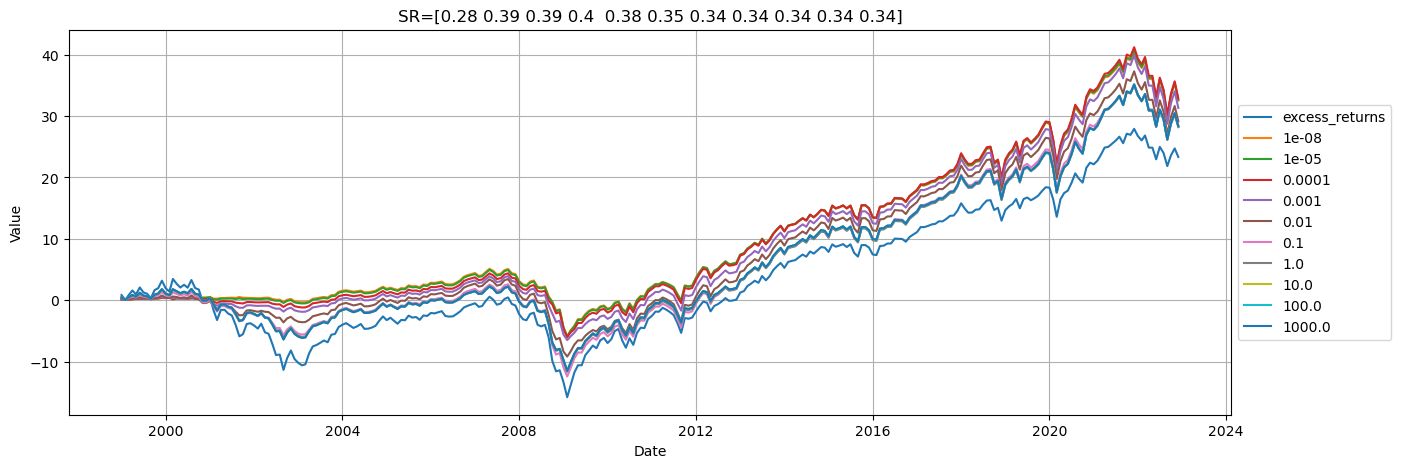

In [25]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(tmp.cumsum(), label = tmp.columns)
ax.set_title(f'SR={sr.values.flatten()}')
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol = 1)
ax.grid()

### NOW COME THE RANDOM FEATURES

The scale of random weights entering random features is very important. The intuition is based on the Taylor approximation. Since $\sin(0)=0,$ we have $\sin(\gamma \cdot \omega'x) \approx \gamma \omega' x$ when $\gamma$ is small enough. That is, our non-linear random features become approximately linear. For a generic activation function, $f(\gamma \cdot \omega'x) \approx\ f(0)+f'(0)\gamma \omega' x$ when $\gamma$ is small. **Thus, the bigger $\gamma$ is, the more non-linear the features are.**

**This scale is also important for neural networks, and is pinned down through initialization!**

In [26]:
P = 50000
d = 14
scale = 1.
theta = scale * np.sqrt(2) * np.random.randn(P, d) / np.sqrt(d)
ins_sin = np.sqrt(2) * np.sin(signals @ theta.T)
ins_cos = np.sqrt(2) * np.cos(signals @ theta.T)
random_features = np.append(ins_sin, ins_cos, axis=1)

In [27]:
random_features.shape

(576, 100000)

In [28]:
split = int(signals.shape[0] / 2)

labels = cleaned_data.excess_returns.values.reshape(-1, 1)

train_labels = labels[:split]
test_labels = labels[split:]

beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=random_features[:split, :],
                                                                labels=train_labels,
                                                                future_signals=random_features[split:, :],
                                                                shrinkage_list=shrinkage_list)

oos_predictions = pd.DataFrame(oos_predictions, index=cleaned_data.index[split:], columns = shrinkage_list)
oos_predictions

,1.000000e-08,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01,1.000000e+00,1.000000e+01,1.000000e+02,1.000000e+03
yyyymm,,,,,,,,,,
1999-01-01,-0.096723,-0.017969,0.004671,0.038288,0.026780,0.006714,0.005834,0.012171,0.015371,0.011567
1999-02-01,-0.022408,0.095155,0.157357,0.126198,0.052066,0.010053,0.002694,0.006991,0.013938,0.011624
1999-03-01,-0.678706,-0.296371,-0.131359,-0.004976,0.017398,0.011839,0.002602,0.006662,0.010410,0.009350
1999-04-01,-0.260249,-0.172324,-0.081398,-0.016203,-0.014302,-0.017188,-0.010665,-0.000236,0.009632,0.009909
1999-05-01,-0.256190,-0.318153,-0.143768,-0.075340,-0.056092,-0.032785,-0.023160,-0.011571,0.003910,0.008151
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,-71.382930,-28.230883,-5.285009,2.900884,2.720208,1.115692,0.328275,0.060144,0.013408,0.003460
2022-09-01,-77.567463,-26.632519,-3.492341,3.636459,2.907810,1.178245,0.343221,0.062836,0.014005,0.003546
2022-10-01,-80.470647,-25.214983,-1.809069,4.310148,3.087029,1.259482,0.373639,0.069950,0.015446,0.003827


In [29]:
market_timing_returns_complex = oos_predictions * test_labels
market_timing_returns_complex.columns = [f'{x}_complex' for x in market_timing_returns_complex.columns]

cleaned_data = pd.concat([cleaned_data, market_timing_returns_complex], axis=1)
tmp = cleaned_data[['excess_returns'] + shrinkage_list + list(market_timing_returns_complex.columns)].iloc[split:, :]
tmp = tmp / tmp.std()
tmp['mean'] = tmp.mean(1)
sr = sharpe_ratio(tmp)

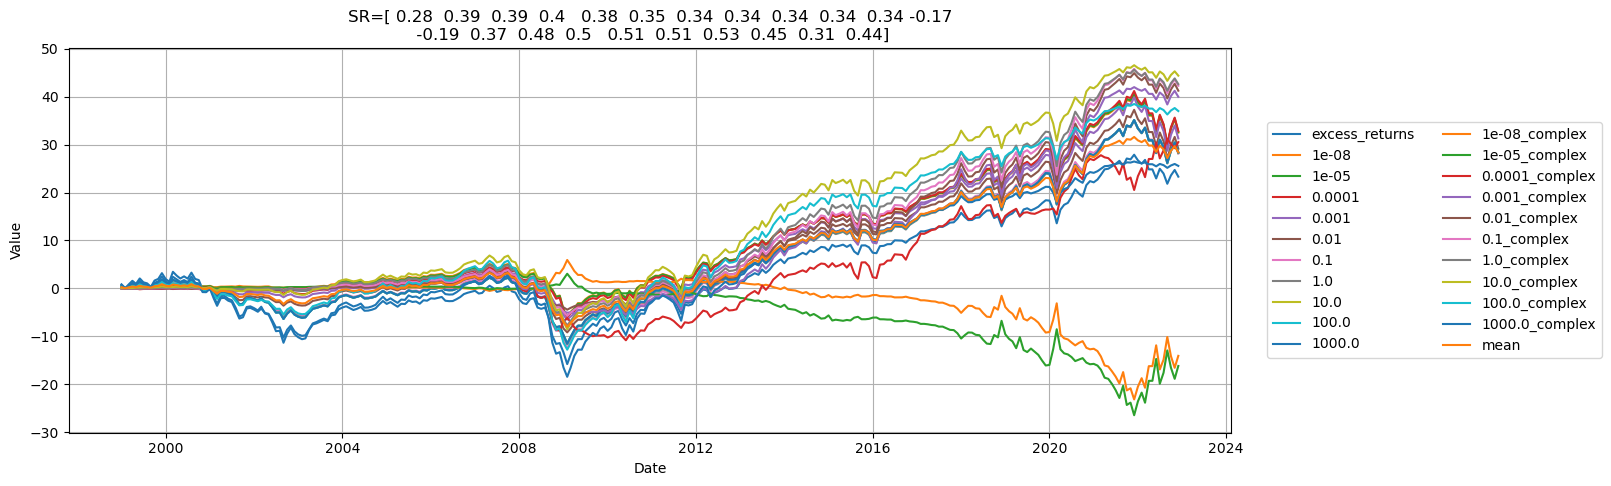

In [30]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(tmp.cumsum(), label = tmp.columns)
ax.set_title(f'SR={sr.values.flatten()}')
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend(loc="center left", bbox_to_anchor=(1.025, 0.5), ncol = 2)
ax.grid()

In [31]:
cleaned_data.corr()[0.0001].to_frame().T

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,...,1e-08_complex,1e-05_complex,0.0001_complex,0.001_complex,0.01_complex,0.1_complex,1.0_complex,10.0_complex,100.0_complex,1000.0_complex
0.0001,0.091859,0.054857,0.027929,-0.019195,-0.087963,-0.140035,-0.152059,-0.12647,0.03348,-0.094756,...,-0.842213,-0.863715,0.213796,0.881605,0.922519,0.928013,0.9208,0.886013,0.8004,0.680345
